文件描述:
* sales_train.csv--2013年1月至2015年10月的每日历史数据.
* test.csv--测试集。您需要预测这些商店和产品在2015年11月的销售情况。
* sample_submission.csv--正确格式的示例提交文件。
* items.csv--关于项目/产品的补充信息。
* item_categories.csv--关于项目类别的补充信息。
* shops.csv--关于商店的csv补充信息。

数据字段：
* ID--表示测试集中的元组(商店、项目)的ID
* shop_id--商店的唯一标识符
* item_id--产品的唯一标识符
* item_category_id--项目类别的唯一标识符
* item_cnt_day--售出的产品数量。你是在预测这个衡量中的每月数量
* item_price--项目的当前价格
* date--日期的格式为 dd/mm/yyyy
* date_block_num--连续的月份号，为了方便使用。2013年1月是0,2013年2月是1,...,2015年10月是33
* item_name--项目的名称
* shop_name--商店名称
* item_category_name--项目类别的名称

问题描述:
* 我们获得了每日的历史销售数据（时间序列）。
* 任务目标是预测测试集的每个商店的产品月销售总量。
* 需要注意的是，商店和产品的列表每个月都有轻微的变化。因此创建一个能够处理这种情况的健壮模型是挑战中的一部分。

#### 导入分析需要的库模块

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set() # 使用初始网格状绘图纸
myfont = matplotlib.font_manager.FontProperties(fname="../input/fontssimhei/simhei.ttf")
plt.rcParams['font.family'] = ['Times New Roman']

#### 数据加载

In [ ]:
sales_train = pd.read_csv('C:/Users/Lenovo/Desktop/金融大数据挖掘期末/sales_train.csv')
items = pd.read_csv('C:/Users/Lenovo/Desktop/金融大数据挖掘期末/items.csv')
item_cats = pd.read_csv('C:/Users/Lenovo/Desktop/金融大数据挖掘期末/item_categories.csv')
shops = pd.read_csv('C:/Users/Lenovo/Desktop/金融大数据挖掘期末/shops.csv')
test = pd.read_csv('C:/Users/Lenovo/Desktop/金融大数据挖掘期末/test.csv')
submission = pd.read_csv('C:/Users/Lenovo/Desktop/金融大数据挖掘期末/sample_submission.csv')

In [ ]:
#查看训练集销售量的前5个和后5个样本
result = pd.concat([sales_train.head(5), sales_train.tail(5)])
print(result)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0
2935848,03.10.2015,33,25,7460,299.00,1.0


In [4]:
#训练集数据形状
print(sales_train.shape)

(2935849, 6)


In [ ]:
import pandas as pd

# 测试集数据（待预测）查看
result = pd.concat([test.head(5), test.tail(5)])
print(result)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


我们需要预测不同ID对应商品（不同种类，存在于不同商店）下个月的销售量大小

### 对数据进行探索性分析

#### 查看销售数据的数据分布情况

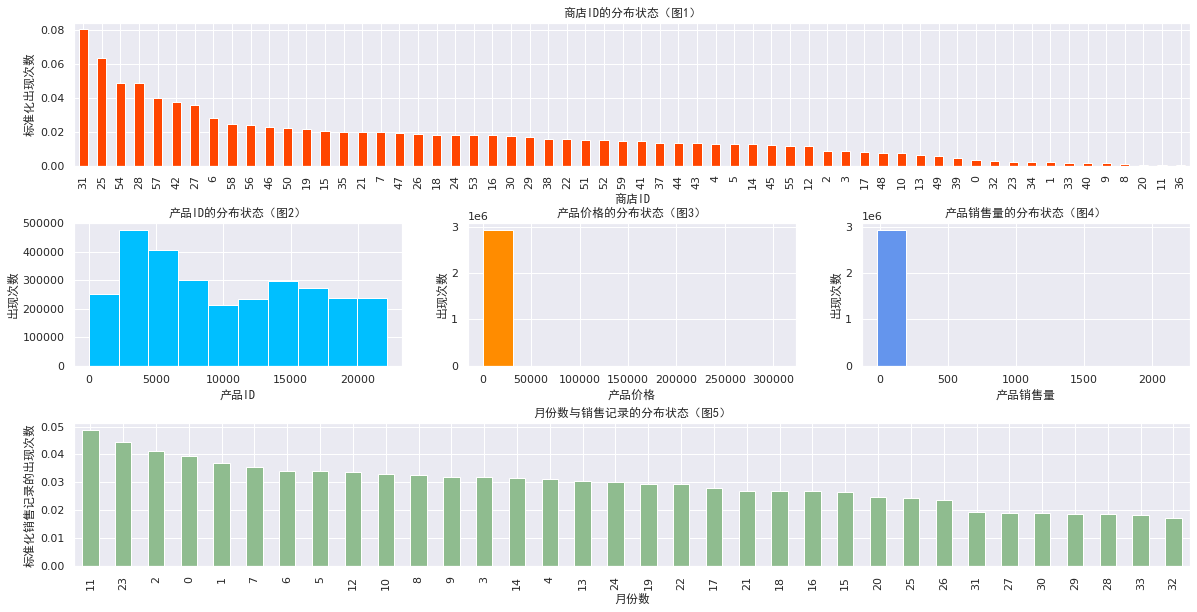

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置字体为系统中的 SimHei（黑体）
myfont = FontProperties(family='SimHei', size=12)

fig = plt.figure(figsize=(20, 10))  # 画布大小设置
plt.subplots_adjust(hspace=.4)  # 调整子图的位置距离，hspace（垂直间距）= 0.4

# 查看 shop_id 的分布
plt.subplot2grid((3, 3), (0, 0), rowspan=1, colspan=3)
sales_train['shop_id'].value_counts(normalize=True).plot(kind='bar', color='orangered')
plt.title('商店ID的分布状态（图1）', fontproperties=myfont)
plt.xlabel('商店ID', fontproperties=myfont)
plt.ylabel('标准化出现次数', fontproperties=myfont)

# 查看 item_id 的分布
plt.subplot2grid((3, 3), (1, 0), rowspan=1, colspan=1)
sales_train['item_id'].plot(kind='hist', color='deepskyblue')
plt.title('产品ID的分布状态（图2）', fontproperties=myfont)
plt.xlabel('产品ID', fontproperties=myfont)
plt.ylabel('出现次数', fontproperties=myfont)

# 查看 item_price 的分布
plt.subplot2grid((3, 3), (1, 1), rowspan=1, colspan=1)
sales_train['item_price'].plot(kind='hist', color='darkorange')
plt.title('产品价格的分布状态（图3）', fontproperties=myfont)
plt.xlabel('产品价格', fontproperties=myfont)
plt.ylabel('出现次数', fontproperties=myfont)

# 查看 item_cnt_day 的分布
plt.subplot2grid((3, 3), (1, 2), rowspan=1, colspan=1)
sales_train['item_cnt_day'].plot(kind='hist', color='cornflowerblue')
plt.title('产品销售量的分布状态（图4）', fontproperties=myfont)
plt.xlabel('产品销售量', fontproperties=myfont)
plt.ylabel('出现次数', fontproperties=myfont)

# 查看 date_block_num 的分布
plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=3)
sales_train['date_block_num'].value_counts(normalize=True).plot(kind='bar', color='darkseagreen')
plt.title('月份数与销售记录的分布状态（图5）', fontproperties=myfont)
plt.xlabel('月份数', fontproperties=myfont)
plt.ylabel('标准化销售记录的出现次数', fontproperties=myfont)

plt.show()

从图像分析可知：
* 图1：我们约有60个商店ID，但是在数据集中它们的分布不太均匀。最多的4个ID占据了整个ID里的25%左右，即31、25、54、28号商店。

* 图2：商品的ID在频率上有些许变化，某些ID的出现次数更多，同一个箱内的商品ID可能代表由相似的产品。

* 图3/图4：从产品价格和产品销量的直方图分布中可见巨大的空白区域，这说明在二者分布中存在着极端的异常值 (如产品价格极大值为30多万，而普遍却在2.5万以内），这些异常值肯定需要处理。

* 图5：这是从2013年1月到2015年10月的月份值数据，可以发现num=11时（2013年12月）有最多的销售记录，且num=23时（2014年12月）有第二多的销售记录，可以推断最多销售发生于每年的年末，这对我们预测2015年11月的数据有一定参考价值。

#### 对于异常值的分析和处理

（1）处理商品的销售价格

In [7]:
#查看排序最大的前五个商品价格
sales_train['item_price'].sort_values(ascending=False)[:5]

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2910156     42990.0
Name: item_price, dtype: float64

In [8]:
#进一步检查该三十多万的售价商品
#在数据中找到对应整体信息
sales_train[sales_train['item_price'] == 307980]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [9]:
#在商品介绍中找到对应信息
items[items['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [10]:
#这是一种俄罗斯的防病毒产品，销售给了522人。我们需要进一步查看数据集中还有无关于此商品的记录
sales_train[sales_train['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [11]:
#显然，只有一条记录是关于此商品名的，故可以当作一个异常值删除
sales_train = sales_train[sales_train['item_price'] < 300000]

In [12]:
#检查极小值端的异常情况
sales_train['item_price'].sort_values(ascending=True)[:5]

484683   -1.0000
608763    0.0700
579766    0.0700
611400    0.0875
673155    0.0900
Name: item_price, dtype: float64

In [13]:
#极小端存在销售价为负的情况，在数据集中进一步检查
sales_train[sales_train['item_price'] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [14]:
#查看该商品的对应信息
sales_train[sales_train['item_id'] == 2973]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.00,13.0
353,16.01.2013,0,25,2973,2499.00,5.0
354,17.01.2013,0,25,2973,2499.00,3.0
355,18.01.2013,0,25,2973,2499.00,2.0
356,19.01.2013,0,25,2973,2499.00,3.0
...,...,...,...,...,...,...
1765321,22.06.2014,17,57,2973,1249.50,1.0
1782298,09.06.2014,17,47,2973,1249.00,1.0
1851765,04.07.2014,18,26,2973,1249.50,1.0
1923837,06.08.2014,19,6,2973,1249.50,1.0


In [15]:
#查看该商品对应的价格信息
price_info = sales_train[sales_train['item_id'] == 2973]['item_price']
price_info.describe()

count     780.000000
mean     2041.627277
std       584.281629
min        -1.000000
25%      1249.500000
50%      2499.000000
75%      2499.000000
max      2499.000000
Name: item_price, dtype: float64

In [16]:
#可见此商品的这个价格是不合理的，而且平均售价在2000以上，故应该删去或填充其他值
#考虑到不同商店同一个商品的售价是不同的，因此应该用其对应的32号商店中此商品的价格中位数代替
price_median = sales_train[(sales_train['shop_id'] == 32) & (sales_train['item_id'] == 2973) & (sales_train['date_block_num'] == 4) & (sales_train['item_price'] > 0)].item_price.median()
sales_train.loc[sales_train['item_price'] < 0, 'item_price'] = price_median

（2）处理商品的销售量

In [17]:
#查看排序最大的前五个商品销售数量
sales_train['item_cnt_day'].sort_values(ascending=False)[:5]

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

In [18]:
#找到最大销售量2169对应的数据信息
sales_train[sales_train['item_cnt_day'] == 2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,28.10.2015,33,12,11373,0.908714,2169.0


In [19]:
#10月份的一天里，11373号产品在12号店就卖出了2169次。
#检查一下这个商品的对应信息。
items[items['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


In [20]:
#借助翻译，这是一种和俄罗斯运输公司“Boxberry”有关的货物商品。
#继续查看此商品在其他商店的销售情况
sales_train[sales_train['item_id'] == 11373]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
58323,08.01.2013,0,12,11373,1000.00,1.0
58324,31.01.2013,0,12,11373,97.80,5.0
176790,01.02.2013,1,12,11373,229.00,1.0
176791,04.02.2013,1,12,11373,130.00,1.0
302468,29.03.2013,2,12,11373,139.50,2.0
...,...,...,...,...,...,...
2909829,07.10.2015,33,12,11373,855.00,2.0
2909830,06.10.2015,33,12,11373,208.80,5.0
2909831,05.10.2015,33,12,11373,140.75,16.0
2909832,02.10.2015,33,12,11373,648.50,2.0


In [21]:
#查看该商品对应的销售量信息
sale_num = sales_train[sales_train['item_id'] == 11373]['item_cnt_day']
sale_num.describe()

count     464.000000
mean       14.144397
std       104.604937
min         1.000000
25%         2.000000
50%         4.000000
75%         8.000000
max      2169.000000
Name: item_cnt_day, dtype: float64

In [22]:
#可见11373这个商品通常卖得很少，销售量几乎在个位数（75％=8件）。
#因此对于销售次数2169可以被认为是一个异常值，应当去除。
sales_train = sales_train[sales_train['item_cnt_day'] < 2000]

In [23]:
#此外注意到还有一个商品销售次数达到1000次，保险起见还需要看一下这个商品
#找到销售量1000对应的数据信息
sales_train[sales_train['item_cnt_day'] == 1000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.0,1000.0


In [24]:
#检查一下这个商品的对应信息。
items[items['item_id'] == 20949]

,item_name,item_id,item_category_id
20949,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,71


In [25]:
#借助翻译，这是一种迈克品牌的白色小包。
#继续查看此商品在其他商店的销售情况
sales_train[sales_train['item_id'] == 20949]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352379,30.04.2013,3,22,20949,5.000000,12.0
352399,29.04.2013,3,22,20949,4.923077,13.0
352400,28.04.2013,3,22,20949,5.000000,4.0
352401,27.04.2013,3,22,20949,5.000000,4.0
352455,24.04.2013,3,22,20949,5.000000,2.0
...,...,...,...,...,...,...
2930644,02.10.2015,33,22,20949,5.000000,1.0
2930645,03.10.2015,33,22,20949,5.000000,2.0
2930646,04.10.2015,33,22,20949,5.000000,3.0
2930647,05.10.2015,33,22,20949,5.000000,2.0


In [26]:
#查看该商品对应的销售量信息
sale_num = sales_train[sales_train['item_id'] == 20949]['item_cnt_day']
sale_num.describe()

count    31340.000000
mean         5.987301
std         11.497655
min        -16.000000
25%          2.000000
50%          3.000000
75%          7.000000
max       1000.000000
Name: item_cnt_day, dtype: float64

In [27]:
#同样地，对于20949这个商品通常卖得很少，销售量几乎在个位数（75％=7件），并且出乎意料地出现了销售量负值
#故对于销售次数1000可以被认为是一个异常值，应当去除。
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

In [28]:
#上面的信息提醒我们还要查验查看排序最小的哪些商品销售数量
sales_train['item_cnt_day'].sort_values(ascending=True)[:10]

1057907   -22.0
1835454   -16.0
2048519    -9.0
59156      -6.0
940092     -6.0
93576      -5.0
2619997    -5.0
2458733    -5.0
59155      -5.0
222426     -4.0
Name: item_cnt_day, dtype: float64

In [29]:
#似乎许多商品都存在销售负值，这可能代表这些商品不仅没有销售反而是进货，因此我们不处理这方面的问题。
#异常值处理暂时到这里结束。

#### 观察测试集的数据分布

现在，让我们对测试集的分布进行查验，观察与训练集是否有区别

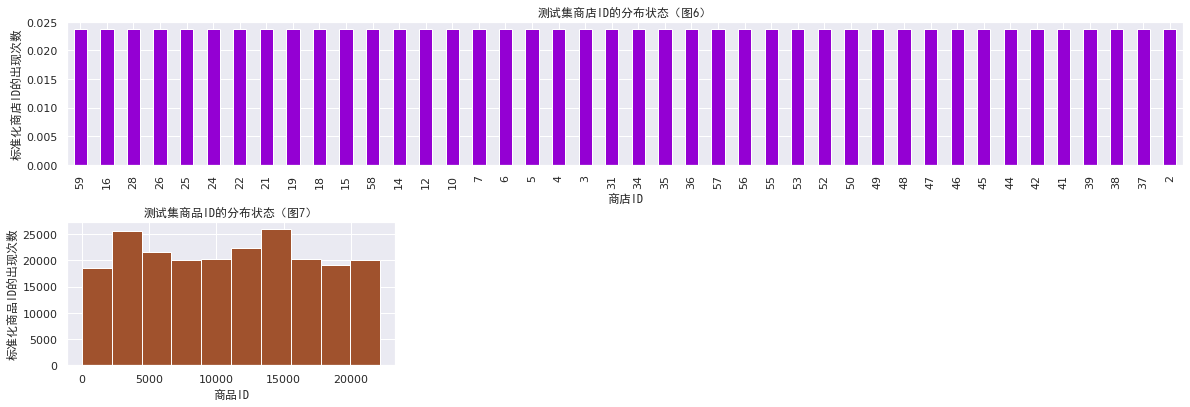

In [30]:
fig = plt.figure(figsize=(20,10))  # 画布
plt.subplots_adjust(hspace=.4)  # 子图间距

#查看shop_id的分布
plt.subplot2grid((3,3), (0,0), rowspan=1, colspan=3)
test['shop_id'].value_counts(normalize=True).plot(kind='bar', color='darkviolet')
plt.title('测试集商店ID的分布状态（图6）',fontproperties=myfont)
plt.xlabel('商店ID',fontproperties=myfont)
plt.ylabel('标准化商店ID的出现次数',fontproperties=myfont)

#查看item_id的分布
plt.subplot2grid((3,3), (1,0), rowspan=1, colspan=1)
test['item_id'].plot(kind='hist', color='sienna')
plt.title('测试集商品ID的分布状态（图7）',fontproperties=myfont)
plt.xlabel('商品ID',fontproperties=myfont)
plt.ylabel('标准化商品ID的出现次数',fontproperties=myfont)

plt.show()

从图像分析可知：
* 图6：与训练集不同，测试集商店Id是均匀分布的。而且分布的稀疏性也说明在测试集中的商店ID相对于训练集是缺失的，即只含有部分的ID。
* 图7：相对于训练集，测试集商品的ID分布更为均匀，但出现的次数会更少。

初步判断，测试集中有一些shop_id和item_id的值丢失了。我们需要对丢失的情况进行统计，并为这些丢失值做一些处理。

##### 商店ID数量分析

In [31]:
#返回训练集和测试集中的商店ID唯一值的数目
shops_train = sales_train['shop_id'].nunique()
shops_test = test['shop_id'].nunique()
print('训练集中的商店ID有 {} 个 '.format(shops_train))
print('测试集中的商店ID有 {} 个 '.format(shops_test))

训练集中的商店ID有 60 个 
测试集中的商店ID有 42 个 


In [32]:
#虽然训练集的ID多于测试集，但这也无法保证训练集包含了出现在测试集中所有的商店。
#因此,需要检验测试集ID是否为训练集ID的一个子集。
def is_subset(set0,set1):
    if set0.issubset(set1):
        print ("二者是子集的包含关系") 
    else:
        print ("二者不是子集的包含关系")

shops_train_set = set(sales_train['shop_id'].unique())
shops_test_set = set(test['shop_id'].unique())

print('判断结果为：')
is_subset(shops_test_set,shops_train_set)

判断结果为：
二者是子集的包含关系


In [33]:
#这里确定了测试集中的所有商店id都在训练集中。
#但是在项目的竞争讨论有一个关于重复店铺的问题被提到，这可能需要我们进行分析。

##### 不同ID的 “重复商店” 分析

In [34]:
#对商店名称和ID进行比较
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


借助翻译，前五个和后五个商店名分别是：（根据ID序号）

（0）雅库茨克·奥尔德奇尼基泽，56弗兰

（1）雅库茨克中心弗兰

（2）阿德盖亚超级购物中心

（3）“十月电影世界”

（4）沃尔日斯基购物中心“伏尔加购物中心”

.........

（55）数字仓库1C-在线

（56）契诃夫嘉年华

（57）雅库茨克·奥尔德奇尼基泽，56

（58）雅库茨克中心

（59）雅罗斯拉夫尔牵牛星购物中心


In [35]:
#令人意外的是这些商店名是以城市和地区作为台头的，这可能是一个潜在特征
#而且仔细分析可以发现ID为0、1的商店名与ID为57、58几乎一致，区别在于商店0、1还附加了'фран'（弗兰）一词
#还有ID为10的商店名与ID为11几乎一致，都为"Жуковский ул. Чкалова 39м"（茹科夫斯基大街·契卡洛夫39m）
#二者唯一区别在于最后的角标字符不同，分别是'？'与'2'

In [36]:
#因此，我认为这些几乎重复的ID项应该被合并（训练集和测试集都要）
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

In [37]:
#再查看一下合并后训练集和测试集的商店ID数目
shops_train = sales_train['shop_id'].nunique()
shops_test = test['shop_id'].nunique()
print('训练集中的商店ID有 {} 个 '.format(shops_train))
print('测试集中的商店ID有 {} 个 '.format(shops_test))

训练集中的商店ID有 57 个 
测试集中的商店ID有 42 个 


可见，测试集中的商店并没有减少，而是训练集中多出的三个冗余ID被去除了。

##### 对商店名中的城市进行提取

In [38]:
#查看前五个ID的商店名
shops['shop_name'][:5]

0     !Якутск Орджоникидзе, 56 фран
1     !Якутск ТЦ "Центральный" фран
2                  Адыгея ТЦ "Мега"
3    Балашиха ТРК "Октябрь-Киномир"
4          Волжский ТЦ "Волга Молл"
Name: shop_name, dtype: object

In [39]:
#提取商店名中的城市名
shop_cities = shops['shop_name'].str.split(' ').str[0]
shop_cities.unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [40]:
#仔细观察后发现雅库茨克市用了'!Якутск'和'Якутск'两种表示。
#猜测它们的含义应该是相同的，所以我们将它们将合并为一类。并且将城市名作为一个新特征放入shops数据里。
shops['city'] = shop_cities
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

In [41]:
#查看现在的shops数据
shops

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский
5,"Вологда ТРЦ ""Мармелад""",5,Вологда
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж
9,Выездная Торговля,9,Выездная


In [42]:
#将city特征转换为数值标签（简单使用数字编码）
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
shops['shop_city'] = label_encoder.fit_transform(shops['city'])

In [43]:
#现在我们不再需要'shop_name'和'city'这两个变量了，所以将其删除
shops = shops.drop(['shop_name', 'city'], axis = 1)
shops.head()

,shop_id,shop_city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


##### 商品ID数量分析

对商品ID“item_ids”也执行类似的分析操作

In [44]:
#返回训练集和测试集中的商品ID唯一值的数目
items_train = sales_train['item_id'].nunique()
items_test = test['item_id'].nunique()
print('训练集中的商品ID有 {} 个 '.format(items_train))
print('测试集中的商品ID有 {} 个 '.format(items_test))

训练集中的商品ID有 21806 个 
测试集中的商品ID有 5100 个 


In [45]:
#类似的包含关系查验
items_train_set = set(sales_train['item_id'].unique())
items_test_set = set(test['item_id'].unique())

print('判断结果为：')
is_subset(items_test_set,items_train_set) 

判断结果为：
二者不是子集的包含关系


意外地，我们发现一些商品只存在于测试集而不在训练集中，我们必须对这些商品进行统计分析。

In [46]:
#确认这些非子集商品ID的数量
len(items_test_set.difference(items_train_set)) 

363

In [47]:
#可见，测试集中存在363项是在训练集中没有的。 
#但这并不意味着针对这些商品的销售预测必须为零的，因为可以将新商品添加到训练数据中，但怎么预测它们的值是一个难题。
#在处理之前，我们需要进一步了解这个测试集中的5100个商品。它们具体属于什么类别，哪些类别我们是不需要在测试集中进行预测的。
item_in_test = items.loc[items['item_id'].isin(sorted(test['item_id'].unique()))]
cats_in_test = item_in_test.item_category_id.unique()

In [48]:
#查看item_cats类别数据中的不在test里的类别信息（训练集中的常见类别）
item_cats.loc[~item_cats['item_category_id'].isin(cats_in_test)]

,item_category_name,item_category_id
1,Аксессуары - PS2,1
4,Аксессуары - PSP,4
8,Билеты (Цифра),8
10,Игровые консоли - PS2,10
13,Игровые консоли - PSP,13
14,Игровые консоли - PSVita,14
17,Игровые консоли - Прочие,17
18,Игры - PS2,18
32,"Карты оплаты (Кино, Музыка, Игры)",32
39,Кино - Blu-Ray 4K,39


##### 对常见的类别进行分组并提取其子类别

由上述列表可知，在类别中还存在主类别和子类别的组合。二者通过连字符 “-” 分隔，需要被我们提取出来。

In [49]:
#查看item_cats中的类别数据
item_cats['item_category_name']

0       PC - Гарнитуры/Наушники
1              Аксессуары - PS2
2              Аксессуары - PS3
3              Аксессуары - PS4
4              Аксессуары - PSP
                ...            
79                    Служебные
80           Служебные - Билеты
81      Чистые носители (шпиль)
82    Чистые носители (штучные)
83             Элементы питания
Name: item_category_name, Length: 84, dtype: object

In [50]:
#以'-'号分隔字符
cats_ = item_cats['item_category_name'].str.split('-')

#提取主类别放入item_cats中
item_cats['main_category'] = cats_.map(lambda row: row[0].strip())  # 提取前面的字符，用strip()用于删除非字符单位

#提取子类别放入item_cats中（若无子类别，则用主类别作为子类别）
item_cats['sub_category'] = cats_.map(lambda row: row[1].strip() if len(row) > 1 else row[0].strip())

In [51]:
#对新类进行数字编码
label_encoder = preprocessing.LabelEncoder()

item_cats['main_category_id'] = label_encoder.fit_transform(item_cats['main_category'])
item_cats['sub_category_id'] = label_encoder.fit_transform(item_cats['sub_category'])

In [52]:
item_cats.head()

,item_category_name,item_category_id,main_category,sub_category,main_category_id,sub_category_id
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,0,29
1,Аксессуары - PS2,1,Аксессуары,PS2,1,9
2,Аксессуары - PS3,2,Аксессуары,PS3,1,10
3,Аксессуары - PS4,3,Аксессуары,PS4,1,11
4,Аксессуары - PSP,4,Аксессуары,PSP,1,13


现在，我们需要对训练集中出现的每个商店和商品生成其对应的销售数据。

由于最终的预测是针对某一特定商店和产品的月度销售数目，因此我们应该以月为单位来做这件事。

##### 在训练数据中的每月生成 Shop-Item-data 元组对

In [53]:
#转换销售数据中的时间比哪里，获取指定形式的时间和日期：'日/月/年'
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')  

In [54]:
#创建一个迭代器，生成表示item1，item2等中元素的笛卡尔积的元组
#表示从2013年1月开始生产的笛卡尔产品
from itertools import product 
shops_in_jan = sales_train.loc[sales_train['date_block_num']==0, 'shop_id'].unique()  # 取出0月份开始的商店ID数
items_in_jan = sales_train.loc[sales_train['date_block_num']==0, 'item_id'].unique()  # 取出0月份开始的商品ID数
jan = list(product(*[shops_in_jan, items_in_jan, [0]]))    # 生成商店ID数与商品ID数的笛卡尔积的元组,然后转成列表

In [55]:
#查看笛卡尔元组的前五个结果，元祖内从左到右位置分别表示：（商店ID，商品ID，当前月份数）
print(jan[:5])

[(59, 22154, 0), (59, 2552, 0), (59, 2554, 0), (59, 2555, 0), (59, 2564, 0)]


In [56]:
#笛卡尔元组的总个数（表示0月份）
print(len(jan))

365175


我们可以看到，2013年1月有365175个商店和物品的元组。

进而我们需要生成训练集中所有33个月的笛卡尔乘积。现在可以生成2013年2月的笛卡尔乘积，并将其与2013年1月连接，就生成一个dataframe了。

In [57]:
#2013年2月（第二个月）生产的笛卡尔产品
shops_in_feb = sales_train.loc[sales_train['date_block_num']==1, 'shop_id'].unique()
items_in_feb = sales_train.loc[sales_train['date_block_num']==1, 'item_id'].unique()
feb = list(product(*[shops_in_feb, items_in_feb, [1]]))

In [58]:
#第二个月的笛卡尔元组
print(feb[:5])

[(50, 3880, 1), (50, 4128, 1), (50, 4124, 1), (50, 3879, 1), (50, 3885, 1)]


In [59]:
#第二个月的笛卡尔元组个数
print(len(feb))

375728


In [60]:
#使用numpy的'vstack'数组堆叠方法将前两个月的笛卡尔元组数据合并，并创造一个dataframe格式便于显示。
cartesian_jf = np.vstack((jan, feb))    # vstack（垂直方向）将数组堆叠。
cartesian_jf_df = pd.DataFrame(cartesian_jf, columns=['shop_id', 'item_id', 'date_block_num'])   # 创建dataframe并给不同列命名
cartesian_jf_df.head().append(cartesian_jf_df.tail())

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0
740898,28,12402,1
740899,28,12870,1
740900,28,12885,1
740901,28,12791,1
740902,28,13433,1


In [61]:
#将所有33个月份进行相同的数据合并与df创建
months = sales_train['date_block_num'].unique()
cartesian = []
for month in months:
    shops_in_month = sales_train.loc[sales_train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = sales_train.loc[sales_train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))
    
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

In [62]:
#所有月份整合后的数据形状
cartesian_df.shape

(10913804, 3)

In [63]:
cartesian_df.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


##### 汇总每月的销售数据，调整目标变量

In [64]:
#对数据集依次使用shop_id,'item_id' 和 'date_block_num' 的序列对象进行分组，然后提取出月销售量'item_cnt_day'的总和
#即可以获得特定商店的特定商品的月销售总量
x = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
x.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,27,0,1.0
1,2,27,17,1.0
2,2,30,2,1.0
3,2,30,5,1.0
4,2,30,15,1.0


In [65]:
x.shape

(1609122, 4)

现在我们需要合并这两个df数据，以发现哪些商店的哪些商品是有销售的：
* 对于笛卡尔元组，我们将简单地放入存在于x中的值。
* 对于其余的行，我们将下标为0表示没有销售。

--  需要注意记住，要合并的列是shop_id、item_id和date_block_num的交集

In [66]:
#pd.merge()方法进行合并连接，left表示只保留左边的主键，只在右边主键中存在的行就不取了
new_train = pd.merge(cartesian_df, x, on=['shop_id', 'item_id', 'date_block_num'], how='left').fillna(0) 

In [67]:
#使用numpy.clip将月销售量item_cnt_month缩放到[0,20]之内，这是项目说明中提到的
new_train['item_cnt_month'] = np.clip(new_train['item_cnt_month'], 0, 20)

In [68]:
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [69]:
#使用sort_values对new_train依次按是按'date_block_num','shop_id','item_id元素内部排序的先后顺序来重新排列
new_train.sort_values(['date_block_num','shop_id','item_id'], inplace = True)  
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0


In [70]:
#删除系统中不需要的列表，释放内存
del x
del cartesian_df
del cartesian
del cartesian_jf
del cartesian_jf_df
del feb
del jan
del items_test_set
del items_train_set
del sales_train

In [71]:
#现在我们为测试集插入date_block_num的属性（第34个月）和销售量'item_cnt_month'属性（暂定为0）。
#使用pandas的insert方法将此新列放置在特定索引处。这便于之后将测试集于训练集的相互连接
test.insert(loc=3, column='date_block_num', value=34)        # 在测试集第三列插入月份数，赋值为34
test['item_cnt_month'] = 0  # 在测试集插入新列'item_cnt_month'，赋值为0
test.head()

,ID,shop_id,item_id,date_block_num,item_cnt_month
0,0,5,5037,34,0
1,1,5,5320,34,0
2,2,5,5233,34,0
3,3,5,5232,34,0
4,4,5,5268,34,0


In [72]:
#删除测试集相对new_train中不含的的ID列，并与原训练集向下连接合并
new_train = new_train.append(test.drop('ID', axis = 1)) 
new_train.head().append(new_train.tail())

,shop_id,item_id,date_block_num,item_cnt_month
114910,2,19,0,0.0
117150,2,27,0,1.0
120623,2,28,0,0.0
118316,2,29,0,0.0
114602,2,32,0,0.0
214195,45,18454,34,0.0
214196,45,16188,34,0.0
214197,45,15757,34,0.0
214198,45,19648,34,0.0
214199,45,969,34,0.0


合并商店、商品和类别数据以添加之前处理好的城市类别标签、商品类别（主类别和子类别）属性

In [73]:
#合并商店数据，以获得对应ID下编码好的的城市类别
new_train = pd.merge(new_train, shops, on=['shop_id'], how='left') 
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_city
0,2,19,0,0.0,0
1,2,27,0,1.0,0
2,2,28,0,0.0,0
3,2,29,0,0.0,0
4,2,32,0,0.0,0


In [74]:
#合并商品名称数据，以获得对应ID下编码好的商品类别
new_train = pd.merge(new_train, items.drop('item_name', axis = 1), on=['item_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_city,item_category_id
0,2,19,0,0.0,0,40
1,2,27,0,1.0,0,19
2,2,28,0,0.0,0,30
3,2,29,0,0.0,0,23
4,2,32,0,0.0,0,40


In [75]:
#合并商品类别数据，以获得对应名称下编码号的商品父子类别
new_train = pd.merge(new_train,  item_cats.drop('item_category_name', axis = 1), on=['item_category_id'], how='left')
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_city,item_category_id,main_category,sub_category,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,Кино,DVD,11,4
1,2,27,0,1.0,0,19,Игры,PS3,5,10
2,2,28,0,0.0,0,30,Игры PC,Стандартные издания,8,55
3,2,29,0,0.0,0,23,Игры,XBOX 360,5,16
4,2,32,0,0.0,0,40,Кино,DVD,11,4


In [76]:
#删除非数值的列
new_train.drop(['main_category','sub_category'],axis=1,inplace=True)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_month,shop_city,item_category_id,main_category_id,sub_category_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [77]:
#删除无用的数据，释放内存
del items
del item_cats
del shops
del test

##### 生成滞后的特征和平均编码

In [78]:
#定义滞后特征添加函数
def generate_lag(train, months, lag_column):
    for month in months:
        # 创建滞后特征
        train_shift = train[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        train_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column+'_lag_'+ str(month)]
        train_shift['date_block_num'] += month
        #新列表连接到训练集中
        train = pd.merge(train, train_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return train

In [79]:
#定义向下数据类型转变函数，作用是将float64类型转变成float16，将int64转变成int16（用于缩减内存量,否则后续无法运行）
from tqdm import tqdm_notebook   # 进度读取条使用
def downcast_dtypes(df):   
    # 选择需要处理的列 
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    #开始数据转换
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

In [80]:
#使用变换函数来更数据类型
new_train = downcast_dtypes(new_train)  

In [81]:
%%time
#添加目标变量（月销量属性）的滞后特征，添加部分的月销量数据
new_train = generate_lag(new_train, [1,2,3,4,5,6,12], 'item_cnt_month')

CPU times: user 44.6 s, sys: 12.6 s, total: 57.1 s
Wall time: 57.1 s


In [82]:
%%time
#添加商品-目标均值的滞后特征
#按月份和商品id排序并取其月销量的均值
group = new_train.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
#将新表添加到new_train的右侧，对应'date_block_num', 'item_id'属性
new_train = pd.merge(new_train, group, on=['date_block_num', 'item_id'], how='left')
#对[1,2,3,6,12]月进行月销量滞后添加（均值填充）
new_train = generate_lag(new_train, [1,2,3,6,12], 'item_month_mean')
#删除不需要的'item_month_mean'属性
new_train.drop(['item_month_mean'], axis=1, inplace=True)

CPU times: user 37.1 s, sys: 11.3 s, total: 48.3 s
Wall time: 48.4 s


In [83]:
%%time
#添加商店-目标均值的滞后特征
group = new_train.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().rename('shop_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id'], how='left')
new_train = generate_lag(new_train, [1,2,3,6,12], 'shop_month_mean')
new_train.drop(['shop_month_mean'], axis=1, inplace=True)

CPU times: user 39.2 s, sys: 12.5 s, total: 51.8 s
Wall time: 51.8 s


In [84]:
%%time
#添加商店-商品种类-目标均值的滞后特征
group = new_train.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].mean().rename('shop_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
new_train = generate_lag(new_train, [1, 2], 'shop_category_month_mean')
new_train.drop(['shop_category_month_mean'], axis=1, inplace=True)

CPU times: user 18.5 s, sys: 6.44 s, total: 24.9 s
Wall time: 25 s


In [85]:
%%time
#添加商品父类别-目标均值的滞后特征
group = new_train.groupby(['date_block_num', 'main_category_id'])['item_cnt_month'].mean().rename('main_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'main_category_id'], how='left')
new_train = generate_lag(new_train, [1], 'main_category_month_mean')
new_train.drop(['main_category_month_mean'], axis=1, inplace=True)

CPU times: user 11 s, sys: 3.92 s, total: 14.9 s
Wall time: 14.9 s


In [86]:
%%time
#添加商品子类别-目标均值的滞后特征
group = new_train.groupby(['date_block_num', 'sub_category_id'])['item_cnt_month'].mean().rename('sub_category_month_mean').reset_index()
new_train = pd.merge(new_train, group, on=['date_block_num', 'sub_category_id'], how='left')
new_train = generate_lag(new_train, [1], 'sub_category_month_mean')
new_train.drop(['sub_category_month_mean'], axis=1, inplace=True)

CPU times: user 13.6 s, sys: 9.79 s, total: 23.4 s
Wall time: 23.4 s


In [87]:
#滞后特征添加后的数据集形貌
new_train.tail()

,shop_id,item_id,date_block_num,item_cnt_month,shop_city,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,item_month_mean_lag_12,shop_month_mean_lag_1,shop_month_mean_lag_2,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,...,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.126831,0.074524,0.146973,0.196899
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,...,NaN,0.126709,0.128784,NaN,NaN,NaN,0.094482,0.117126,0.237305,0.155884
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,...,0.180054,0.126709,0.128784,0.139038,0.137573,0.181274,0.126831,0.074524,0.146973,0.196899
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,...,NaN,0.126709,0.128784,0.139038,0.137573,NaN,0.083740,0.074097,0.224243,0.220825
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,...,0.119995,0.126709,0.128784,0.139038,0.137573,0.181274,0.128174,0.067444,0.224243,0.240967


In [88]:
#添加一个月属性的特征
new_train['month'] = new_train['date_block_num'] % 12

In [89]:
#添加一个月份中休假日期特征
#每一个月份对应的休息天数字典
holiday_dict = {0: 6,
                1: 3,
                2: 2,
                3: 8,
                4: 3,
                5: 3,
                6: 2,
                7: 8,
                8: 4,
                9: 8,
                10: 5,
                11: 4}

new_train['holidays_in_month'] = new_train['month'].map(holiday_dict)

In [90]:
#添加已知的第二年开始俄罗斯证券交易所交易数据(万亿)特征
moex = {12: 659, 
        13: 640, 
        14: 1231,
        15: 881,
        16: 764, 
        17: 663,
        18: 743, 
        19: 627, 
        20: 692,
        21: 736, 
        22: 680, 
        23: 1092,
        24: 657, 
        25: 863, 
        26: 720,
        27: 819, 
        28: 574, 
        29: 568,
        30: 633, 
        31: 658, 
        32: 611,
        33: 770, 
        34: 723}

new_train['moex'] = new_train.date_block_num.map(moex)

In [91]:
#再一次数据类型转换
new_train = downcast_dtypes(new_train)
new_train.head().append(new_train.tail())

,shop_id,item_id,date_block_num,item_cnt_month,shop_city,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1,month,holidays_in_month,moex
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6,NaN
11127999,45,18454,34,0.0,20,55,13,2,1.0,0.0,...,0.139038,0.137573,NaN,0.126831,0.074524,0.146973,0.196899,10,5,723.0
11128000,45,16188,34,0.0,20,64,14,42,0.0,0.0,...,NaN,NaN,NaN,0.094482,0.117126,0.237305,0.155884,10,5,723.0
11128001,45,15757,34,0.0,20,55,13,2,0.0,0.0,...,0.139038,0.137573,0.181274,0.126831,0.074524,0.146973,0.196899,10,5,723.0
11128002,45,19648,34,0.0,20,40,11,4,0.0,0.0,...,0.139038,0.137573,NaN,0.083740,0.074097,0.224243,0.220825,10,5,723.0
11128003,45,969,34,0.0,20,37,11,1,0.0,0.0,...,0.139038,0.137573,0.181274,0.128174,0.067444,0.224243,0.240967,10,5,723.0


#### 数据集切分

In [92]:
#因为第一年没有俄罗斯证券交易的数据特征，因此从第二年开始作为输入
new_train = new_train[new_train.date_block_num > 11]

In [93]:
#使用0来填补，表示没有数据的样本
def fill_nan(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isna().any()):
            df[col].fillna(0, inplace=True)         
    return df

new_train =  fill_nan(new_train)

##### 训练集

In [94]:
#训练数据的特征提取
train_feature = new_train[new_train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
#训练数据的标签提取
train_label = new_train[new_train.date_block_num < 33]['item_cnt_month']

##### 验证集

In [95]:
#验证数据的特征提取
val_feature = new_train[new_train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
#验证数据的标签提取
val_label = new_train[new_train.date_block_num == 33]['item_cnt_month']

##### 测试集（待预测）

In [96]:
test_feature = new_train[new_train.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [97]:
train_feature.shape,train_label.shape,val_feature.shape,val_label.shape

((6186922, 31), (6186922,), (238172, 31), (238172,))

In [98]:
train_feature.head()

,shop_id,item_id,date_block_num,shop_city,item_category_id,main_category_id,sub_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,...,shop_month_mean_lag_3,shop_month_mean_lag_6,shop_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,main_category_month_mean_lag_1,sub_category_month_mean_lag_1,month,holidays_in_month,moex
4488710,2,27,12,0,19,5,10,0.0,0.0,0.0,...,0.08905,0.096008,0.141235,0.955566,0.571289,1.03418,1.075195,0,6,659.0
4488711,2,30,12,0,40,11,4,0.0,0.0,0.0,...,0.08905,0.096008,0.000000,0.046234,0.022934,0.27002,0.291504,0,6,659.0
4488712,2,31,12,0,37,11,1,0.0,0.0,0.0,...,0.08905,0.096008,0.000000,0.059448,0.046814,0.27002,0.234009,0,6,659.0
4488713,2,32,12,0,40,11,4,0.0,0.0,0.0,...,0.08905,0.096008,0.141235,0.046234,0.022934,0.27002,0.291504,0,6,659.0
4488714,2,33,12,0,37,11,1,1.0,2.0,0.0,...,0.08905,0.096008,0.141235,0.059448,0.046814,0.27002,0.234009,0,6,659.0


In [99]:
import gc
gc.collect()

23052

### 模型搭建与优化

#### 使用XGBOOST模型进行预测

In [100]:
from xgboost import XGBRegressor

In [101]:
#设定模型参数
model = XGBRegressor(n_estimators=3000,
                     max_depth=10,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.01
                    )

In [102]:
%%time
#进行模型训练，并设置早停函数(建议在kaggle端进行)
model.fit(train_feature.values, train_label.values, 
          eval_metric="rmse", 
          eval_set=[(train_feature.values, train_label.values), (val_feature.values, val_label.values)], 
          verbose=True, 
          early_stopping_rounds = 50)

[07:33:04] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.20341	validation_1-rmse:1.15790
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.19964	validation_1-rmse:1.15431
[2]	validation_0-rmse:1.19618	validation_1-rmse:1.15051
[3]	validation_0-rmse:1.19220	validation_1-rmse:1.14701
[4]	validation_0-rmse:1.18785	validation_1-rmse:1.14315
[5]	validation_0-rmse:1.18371	validation_1-rmse:1.13949
[6]	validation_0-rmse:1.17886	validation_1-rmse:1.13612
[7]	validation_0-rmse:1.17300	validation_1-rmse:1.13222
[8]	validation_0-rmse:1.16833	validation_1-rmse:1.12895
[9]	validation_0-rmse:1.16363	validation_1-rmse:1.12522
[10]	validation_0-rmse:1.15895	validation_1-rmse:1.12146
[11]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='approx', validate_parameters=1, verbosity=None)

#### 结果预测

In [103]:
#导出预测结果
y_pred = model.predict(test_feature.values)

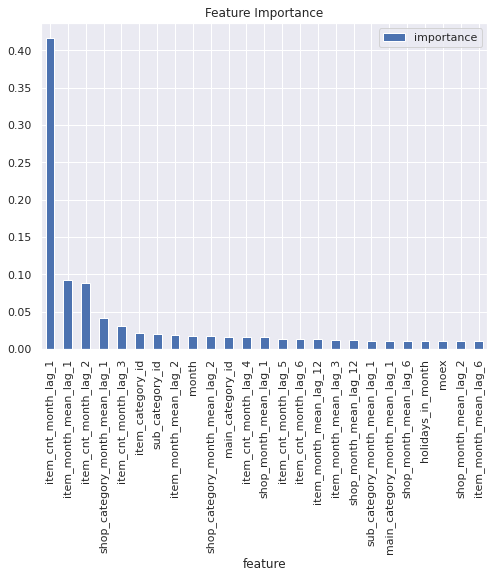

In [104]:
#特征重要性查看
importances = pd.DataFrame({'feature':new_train.drop('item_cnt_month', axis = 1).columns,'importance':np.round(model.feature_importances_,3)}) 
importances = importances.sort_values('importance',ascending=False).set_index('feature') 
importances = importances[importances['importance'] > 0.01]

importances.plot(kind='bar',
                 title = 'Feature Importance',
                 figsize = (8,6),
                 grid= 'both')

#### 提交结果

In [105]:
submission['item_cnt_month'] = y_pred
submission.to_csv('future_sales_pred.csv', index=False)